In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from models import resnet
import dill

# Attack types

def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=10, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

# Epoch types

def epoch_base(loader, model,device, opt=None,):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model( X )
        loss = nn.CrossEntropyLoss()( yp, y )
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def epoch_AT_vanilla(loader, model,device, opt=None,):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = pgd_linf(model, X, y)
        yp = model( X + delta )
        loss = nn.CrossEntropyLoss()( yp, y )
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def epoch_fast_AT(loader, model, device, opt=None,):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = fgsm(model, X, y, epsilon=0.1) #pgd_linf(model, X, y)
        yp = model( X + delta )
        loss = nn.CrossEntropyLoss()( yp, y )
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
        
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def epoch_free_AT(loader, model, device, opt=None,):

    num_repeats=10
    epsilon=0.1
    alpha=0.01

    total_loss, total_err = 0., 0.
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        delta = torch.zeros_like(X, requires_grad=True)  # Initialize perturbation

        for _ in range(num_repeats):  # Update the adversarial example in-place
            yp = model(X + delta)  # Prediction on perturbed data
            loss = nn.CrossEntropyLoss()(yp, y)
            opt.zero_grad()
            loss.backward()  # Gradients w.r.t. delta and model parameters

            # Update delta within its allowable range and clamp
            delta.data = (delta + X.shape[0] * alpha * delta.grad.data).clamp(-epsilon, epsilon)
            delta.grad.zero_()

            # Update model parameters
            opt.step()

            total_err += (yp.max(dim=1)[1] != y).sum().item()
            total_loss += loss.item() * X.shape[0]

    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

# Training loop

def launch_experiment(model, device, train_loader, test_loader, opt, epochs, epoch_fn):

    print(*("{}".format(i) for i in ("Train Err", "Test Err", "Adv Err")), sep="\t")

    for _ in tqdm(range(epochs)):

        train_err, train_loss = epoch_fn(train_loader, model, device, opt)
        test_err, test_loss = epoch_base(test_loader, model,device)
        adv_err, adv_loss = epoch_AT_vanilla(test_loader, model,device, opt)
        print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")



In [4]:
device = 'cuda'
import models 
# from robustness.datasets import CIFAR

# Load the dataset
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize( (0.1307,), (0.3081,) )  # MNIST mean and std
# ])
# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# CIFAR10 normalization values for RGB channels
mean_cifar10 = (0.4914, 0.4822, 0.4465)
std_cifar10 = (0.2023, 0.1994, 0.2010)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10, std_cifar10)
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# model = LeNet().to(device)
model = models.resnet.resnet50(pretrained=True, progress=True, device="cuda").to('cuda')


# optimizer = optim.Adam(model.parameters(), lr=0.001)

# launch_experiment(model, device, train_loader, test_loader, optimizer, 10, epoch_base)

# torch.save(model.state_dict(), './models/vanilla_model.pth')

# model.load_state_dict(torch.load('./models/vanilla_model.pth'))


Files already downloaded and verified


In [5]:
def compute_clean_accuracy(model, test_loader, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

from autoattack import AutoAttack

def compute_robust_accuracy(model, test_loader, epsilon, norm='Linf', device='cuda'):
    """
    Compute the robust accuracy of the model using AutoAttack.
    
    Parameters:
    - model: The PyTorch model to evaluate.
    - test_loader: DataLoader for the test dataset.
    - epsilon: Float, the maximum perturbation size.
    - norm: String, the norm ('Linf', 'L2', 'L1') for the attack.
    - device: String, the device to perform computations on.
    
    Returns:
    - robust_accuracy: Float, the accuracy of the model on adversarial examples.
    """
    model.eval()

    def forward_pass(x):
        return model(x)
    
    adversary = AutoAttack(forward_pass, norm=norm, eps=epsilon, version='standard')
    
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        x_adv = adversary.run_standard_evaluation(images, labels, bs=images.size(0))
        
        # Evaluate the model on adversarial examples
        outputs = model(x_adv)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    robust_accuracy = 100 * correct / total
    return robust_accuracy


In [6]:
accuracy = compute_clean_accuracy(model, test_loader)
print(f'The clean accuracy of the model on the test set is {accuracy}%')

epsilon = 8/255
accuracy = compute_robust_accuracy(model, test_loader, epsilon, norm='Linf', device='cuda')
print(f'The robust accuracy of the model on the test set is {accuracy}%')

The clean accuracy of the model on the test set is 92.78%
setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 2.94 GiB of which 14.12 MiB is free. Including non-PyTorch memory, this process has 2.92 GiB memory in use. Of the allocated memory 2.61 GiB is allocated by PyTorch, and 223.69 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [4]:
launch_experiment(model, device, train_loader, test_loader, optimizer, 20, epoch_AT_vanilla)

Train Err	Test Err	Adv Err


  0%|          | 0/20 [00:00<?, ?it/s]

0.112550	0.020900	0.040600
0.039983	0.016300	0.033000
0.030117	0.011900	0.030900
0.025800	0.012600	0.025900
0.023600	0.009500	0.022500
0.019617	0.008200	0.022300
0.018083	0.010200	0.021000
0.016300	0.010500	0.021500
0.015217	0.006700	0.020500
0.013550	0.008700	0.021400
0.012383	0.009200	0.020500
0.012433	0.008500	0.022100
0.010983	0.007900	0.020000
0.009767	0.006800	0.019400
0.009983	0.006900	0.019200
0.008517	0.008600	0.021000
0.008683	0.007400	0.019600
0.008083	0.006200	0.017900
0.007750	0.007200	0.018800
0.007033	0.005700	0.017000


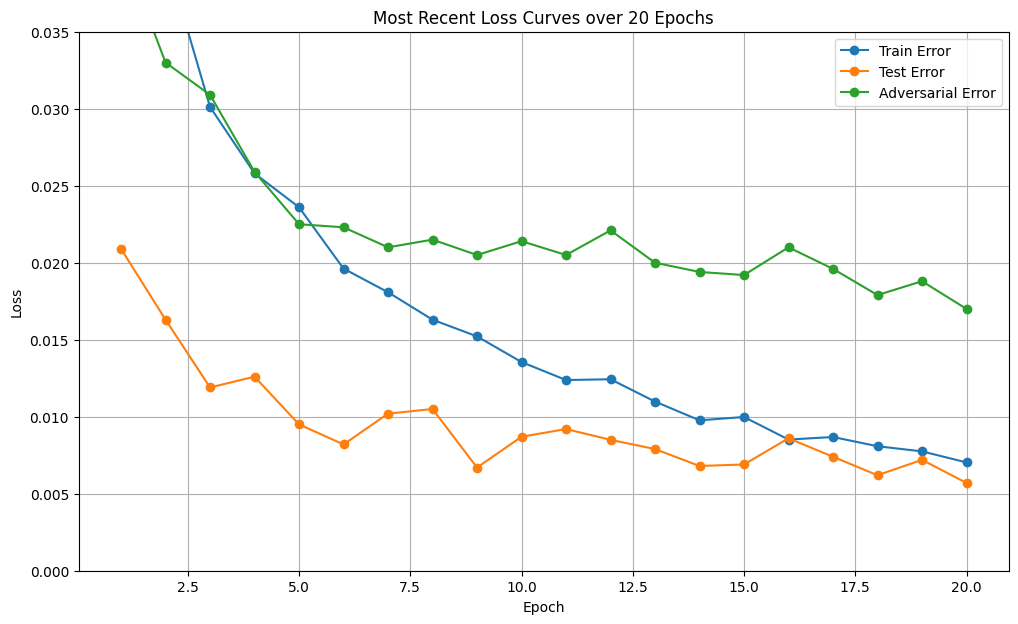

In [10]:
import matplotlib.pyplot as plt


# Newest data for more epochs
latest_data = {
    "Train Err": [
        0.112550, 0.039983, 0.030117, 0.025800, 0.023600, 0.019617, 0.018083,
        0.016300, 0.015217, 0.013550, 0.012383, 0.012433, 0.010983, 0.009767,
        0.009983, 0.008517, 0.008683, 0.008083, 0.007750, 0.007033
    ],
    "Test Err": [
        0.020900, 0.016300, 0.011900, 0.012600, 0.009500, 0.008200, 0.010200,
        0.010500, 0.006700, 0.008700, 0.009200, 0.008500, 0.007900, 0.006800,
        0.006900, 0.008600, 0.007400, 0.006200, 0.007200, 0.005700
    ],
    "Adv Err": [
        0.040600, 0.033000, 0.030900, 0.025900, 0.022500, 0.022300, 0.021000,
        0.021500, 0.020500, 0.021400, 0.020500, 0.022100, 0.020000, 0.019400,
        0.019200, 0.021000, 0.019600, 0.017900, 0.018800, 0.017000
    ]
}

# Updated epochs for the new data set
extended_epochs = list(range(1, 21))

# Plotting the latest errors
plt.figure(figsize=(12, 7))
plt.plot(extended_epochs, latest_data["Train Err"], label="Train Error", marker='o')
plt.plot(extended_epochs, latest_data["Test Err"], label="Test Error", marker='o')
plt.plot(extended_epochs, latest_data["Adv Err"], label="Adversarial Error", marker='o')

# Labeling the axes and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Most Recent Loss Curves over 20 Epochs")
plt.legend()
plt.ylim((0, 0.035))
plt.grid(True)


plt.savefig('./figures/full_adversarial_training.png')  # Saves the figure to a file named 'loss_curves.png'

plt.show()


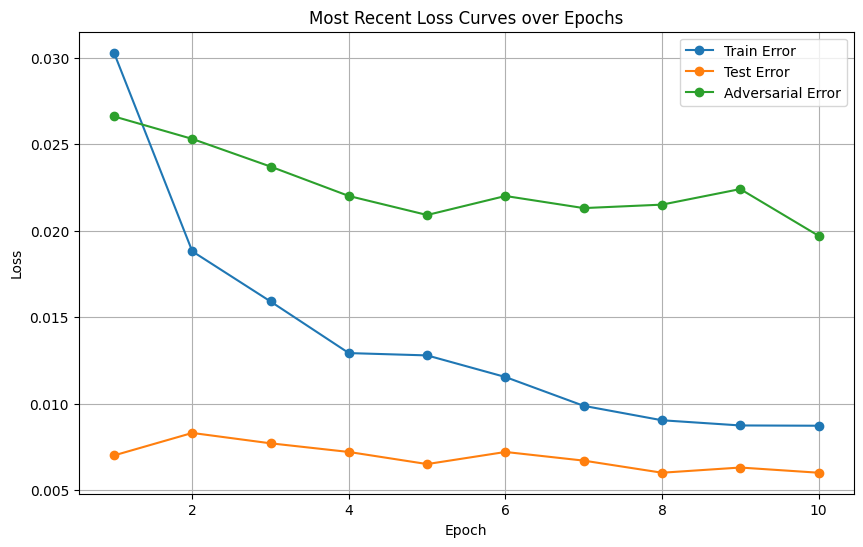

In [6]:
# Even newer data provided by the user
import matplotlib.pyplot as plt

newer_data = {
    "Train Err": [0.030283, 0.018800, 0.015900, 0.012917, 0.012783, 0.011533, 0.009867, 0.009033, 0.008733, 0.008717],
    "Test Err": [0.007000, 0.008300, 0.007700, 0.007200, 0.006500, 0.007200, 0.006700, 0.006000, 0.006300, 0.006000],
    "Adv Err": [0.026600, 0.025300, 0.023700, 0.022000, 0.020900, 0.022000, 0.021300, 0.021500, 0.022400, 0.019700]
}

epochs = list(range(1, 11))

# Plotting the newer errors
plt.figure(figsize=(10, 6))
plt.plot(epochs, newer_data["Train Err"], label="Train Error", marker='o')
plt.plot(epochs, newer_data["Test Err"], label="Test Error", marker='o')
plt.plot(epochs, newer_data["Adv Err"], label="Adversarial Error", marker='o')

# Labeling the axes and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Most Recent Loss Curves over Epochs")
plt.legend()

plt.grid(True)
plt.savefig('./figures/adversarial_training.png')  # Saves the figure to a file named 'loss_curves.png'

plt.show()

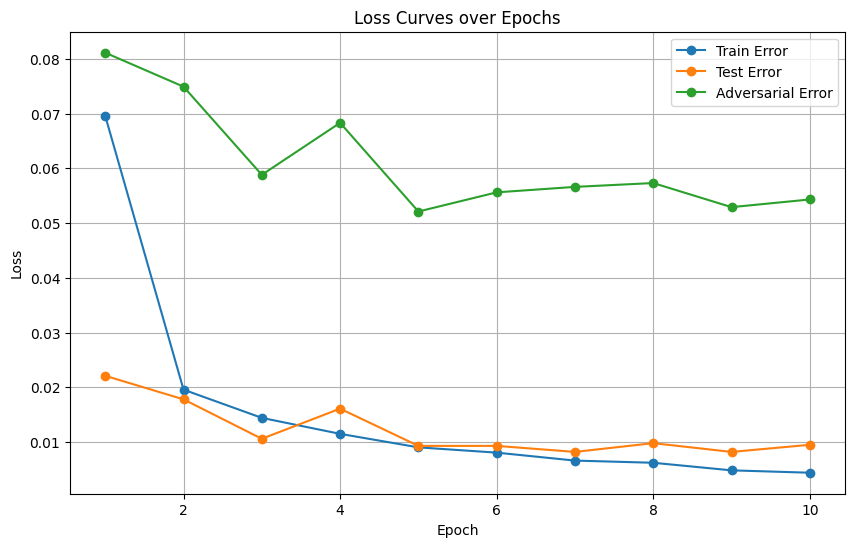

In [8]:
import matplotlib.pyplot as plt


# Define your data and epochs
data = {
    "Train Err": [0.069550, 0.019567, 0.014417, 0.011500, 0.009033, 0.008067, 0.006617, 0.006217, 0.004833, 0.004400],
    "Test Err": [0.022100, 0.017800, 0.010600, 0.016100, 0.009300, 0.009300, 0.008200, 0.009800, 0.008200, 0.009500],
    "Adv Err": [0.081100, 0.074900, 0.058800, 0.068300, 0.052100, 0.055600, 0.056600, 0.057300, 0.052900, 0.054300]
}
epochs = list(range(1, 11))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, data["Train Err"], label="Train Error", marker='o')
plt.plot(epochs, data["Test Err"], label="Test Error", marker='o')
plt.plot(epochs, data["Adv Err"], label="Adversarial Error", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves over Epochs")
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('./figures/vanilla_training.png')  # Saves the figure to a file named 'loss_curves.png'

# Show the plot
plt.show()

In [9]:
import math
from functools import partial

import torch
import torch.nn.utils.parametrize as parametrize
from torch import nn



# Setting up LoRA class which adds two trainable matrices on top of the layers's original weights W
class LoRA(nn.Module):
    def __init__(self, features_in, features_out, rank=1, alpha=1, device=device):
        super().__init__()

        self.mat_A = nn.Parameter(torch.zeros((rank,features_out)).to(device))
        self.mat_B = nn.Parameter(torch.zeros((features_in, rank)).to(device))
        nn.init.normal_(self.mat_A, mean=0, std=1)

        self.scale = alpha / rank


    def forward(self, W):
        return W + torch.matmul(self.mat_B, self.mat_A).view(W.shape) * self.scale

     

#This function takes the layer as the input and sets the features_in,features_out
#equal to the shape of the weight matrix. This will help the LoRA class to
#initialize the A and B Matrices

def layer_parametrization(layer, device, rank = 10, lora_alpha = 1):
  print( layer.weight.shape, type(layer) )
  if type(layer) == nn.Linear:
    features_in, features_out = layer.weight.shape
  elif type(layer) == nn.Conv2d:
     features_out, features_in = layer.weight.view(layer.weight.shape[0], -1).shape
  else:
     print('error')
  
  return LoRA(features_in, features_out, rank = rank, alpha = lora_alpha, device = device)
     


In [10]:
import torch
# import lora 
# import utils
from functools import partial
import torch.nn.utils.parametrize as parametrize

parametrize.register_parametrization(model.fc1, 'weight', layer_parametrization(model.fc1, device))
parametrize.register_parametrization(model.fc2, 'weight', layer_parametrization(model.fc2, device))
parametrize.register_parametrization(model.fc3, 'weight', layer_parametrization(model.fc3, device))

parametrize.register_parametrization(model.conv1, 'weight', layer_parametrization(model.conv1, device))
parametrize.register_parametrization(model.conv2, 'weight', layer_parametrization(model.conv2, device))


torch.Size([120, 400]) <class 'torch.nn.modules.linear.Linear'>
torch.Size([84, 120]) <class 'torch.nn.modules.linear.Linear'>
torch.Size([10, 84]) <class 'torch.nn.modules.linear.Linear'>
torch.Size([6, 1, 5, 5]) <class 'torch.nn.modules.conv.Conv2d'>
torch.Size([16, 6, 5, 5]) <class 'torch.nn.modules.conv.Conv2d'>


ParametrizedConv2d(
  6, 16, kernel_size=(5, 5), stride=(1, 1)
  (parametrizations): ModuleDict(
    (weight): ParametrizationList(
      (0): LoRA()
    )
  )
)

In [11]:
for name, param in model.named_parameters():
    if 'mat' not in name:
        print(f'Freezing non-LoRA parameter {name}')
        param.requires_grad = False

for layer in [model.fc1, model.fc2, model.fc3, model.conv1, model.conv2 ]:
  layer.parametrizations["weight"][0].requires_grad = True

Freezing non-LoRA parameter conv1.bias
Freezing non-LoRA parameter conv1.parametrizations.weight.original
Freezing non-LoRA parameter conv2.bias
Freezing non-LoRA parameter conv2.parametrizations.weight.original
Freezing non-LoRA parameter fc1.bias
Freezing non-LoRA parameter fc1.parametrizations.weight.original
Freezing non-LoRA parameter fc2.bias
Freezing non-LoRA parameter fc2.parametrizations.weight.original
Freezing non-LoRA parameter fc3.bias
Freezing non-LoRA parameter fc3.parametrizations.weight.original


In [12]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Shape: {param.size()}")

Parameter: conv1.parametrizations.weight.0.mat_A, Shape: torch.Size([10, 6])
Parameter: conv1.parametrizations.weight.0.mat_B, Shape: torch.Size([25, 10])
Parameter: conv2.parametrizations.weight.0.mat_A, Shape: torch.Size([10, 16])
Parameter: conv2.parametrizations.weight.0.mat_B, Shape: torch.Size([150, 10])
Parameter: fc1.parametrizations.weight.0.mat_A, Shape: torch.Size([10, 400])
Parameter: fc1.parametrizations.weight.0.mat_B, Shape: torch.Size([120, 10])
Parameter: fc2.parametrizations.weight.0.mat_A, Shape: torch.Size([10, 120])
Parameter: fc2.parametrizations.weight.0.mat_B, Shape: torch.Size([84, 10])
Parameter: fc3.parametrizations.weight.0.mat_A, Shape: torch.Size([10, 84])
Parameter: fc3.parametrizations.weight.0.mat_B, Shape: torch.Size([10, 10])


In [7]:
print( model.fc1.parametrizations.weight.original )
print( model.fc1.parametrizations.weight[0].mat_A )
print( model.fc1.parametrizations.weight[0].mat_B )
# print()
# print( model.fc2.parametrizations.weight.original )
# print( model.fc2.parametrizations.weight[0].mat_A )
# print( model.fc2.parametrizations.weight[0].mat_B )
# print()
# print( model.fc3.parametrizations.weight.original )
# print( model.fc3.parametrizations.weight[0].mat_A )
# print( model.fc3.parametrizations.weight[0].mat_B )

Parameter containing:
tensor([[ 0.4101,  0.6101, -0.7784,  ...,  0.1910, -0.3317,  0.3116],
        [ 0.2397, -0.1602, -0.0614,  ..., -0.0139,  0.7553, -0.2833],
        [-0.2825, -0.0330, -0.0121,  ...,  0.6242,  0.4241,  0.2875],
        ...,
        [ 0.1932, -0.4889,  0.1380,  ..., -1.0026,  0.1322, -0.7923],
        [-0.1220, -0.6803, -0.4610,  ..., -1.7360, -2.0502, -0.9297],
        [ 0.1274,  0.1923, -0.3626,  ...,  0.2435, -0.0061, -0.6971]],
       device='cuda:0')
Parameter containing:
tensor([[ 1.0237,  2.3277,  0.5159,  ...,  0.6318,  2.4288, -0.7124],
        [-0.3716, -0.5766,  0.9423,  ..., -0.8813, -0.2781,  1.4706],
        [-1.2525,  0.8873,  0.1686,  ...,  1.5745,  0.8411,  0.6783],
        ...,
        [ 1.0775,  0.0986,  0.1755,  ...,  1.4628,  0.7023, -0.1758],
        [ 0.2817, -0.7649,  0.3903,  ..., -1.2763, -0.8289, -0.5388],
        [ 0.8893, -0.0819, -1.3088,  ..., -1.1900,  0.2089,  1.9781]],
       device='cuda:0', requires_grad=True)
Parameter containing

In [13]:
lora_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
launch_experiment(model, 'cuda', train_loader, test_loader, lora_optimizer, 10, epoch_AT_vanilla) #epoch_free_



Train Err	Test Err	Adv Err


  0%|          | 0/10 [00:00<?, ?it/s]

0.032483	0.006000	0.030700
0.025067	0.005600	0.029000
0.022367	0.005600	0.028700
0.021000	0.005100	0.026400
0.018800	0.005000	0.026000
0.018250	0.005400	0.025300
0.017200	0.005600	0.025300
0.016033	0.005100	0.023800
0.015683	0.005400	0.024800
0.014933	0.005700	0.025700


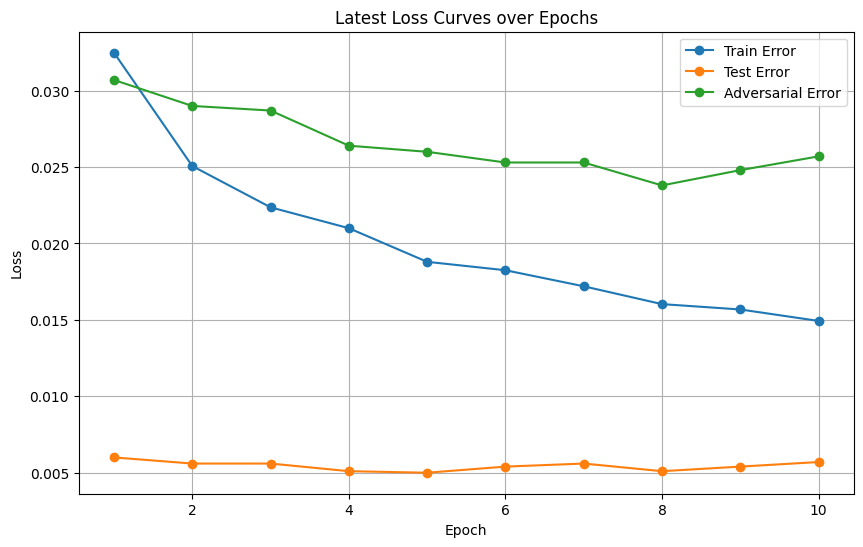

In [14]:
# New data provided by the user
new_data = {
    "Train Err": [0.032483, 0.025067, 0.022367, 0.021000, 0.018800, 0.018250, 0.017200, 0.016033, 0.015683, 0.014933],
    "Test Err": [0.006000, 0.005600, 0.005600, 0.005100, 0.005000, 0.005400, 0.005600, 0.005100, 0.005400, 0.005700],
    "Adv Err": [0.030700, 0.029000, 0.028700, 0.026400, 0.026000, 0.025300, 0.025300, 0.023800, 0.024800, 0.025700]
}

# Plotting the new errors
plt.figure(figsize=(10, 6))
plt.plot(epochs, new_data["Train Err"], label="Train Error", marker='o')
plt.plot(epochs, new_data["Test Err"], label="Test Error", marker='o')
plt.plot(epochs, new_data["Adv Err"], label="Adversarial Error", marker='o')

# Labeling the axes and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Latest Loss Curves over Epochs")
plt.legend()

plt.grid(True)

# Save the figure
plt.savefig('./figures/lora_training.png')  # Saves the figure to a file named 'loss_curves.png'
plt.show()

In [ ]:
# torch.save(model.state_dict(), './models/lora_robust_model.pth')
# model.load_state_dict(torch.load('./models/lora_robust_model.pth'))

In [11]:
print( model.fc1.parametrizations.weight.original )
print( model.fc1.parametrizations.weight[0].mat_A )
print( model.fc1.parametrizations.weight[0].mat_B )

Parameter containing:
tensor([[ 0.4101,  0.6101, -0.7784,  ...,  0.1910, -0.3317,  0.3116],
        [ 0.2397, -0.1602, -0.0614,  ..., -0.0139,  0.7553, -0.2833],
        [-0.2825, -0.0330, -0.0121,  ...,  0.6242,  0.4241,  0.2875],
        ...,
        [ 0.1932, -0.4889,  0.1380,  ..., -1.0026,  0.1322, -0.7923],
        [-0.1220, -0.6803, -0.4610,  ..., -1.7360, -2.0502, -0.9297],
        [ 0.1274,  0.1923, -0.3626,  ...,  0.2435, -0.0061, -0.6971]],
       device='cuda:0')
Parameter containing:
tensor([[ 1.3103, -0.4103,  0.0046,  ..., -0.8584,  0.7383, -0.5054],
        [-0.0478,  1.4575, -1.2261,  ..., -0.8725,  1.6047,  1.0097],
        [-2.4463, -1.7865, -0.6676,  ..., -1.1606, -0.0412, -0.9194],
        ...,
        [ 1.4791,  0.7601,  1.6334,  ..., -1.4139, -1.5080,  2.5790],
        [ 1.3305, -1.0195, -1.3983,  ..., -0.4185,  2.0925,  0.0480],
        [ 1.5384,  0.2918,  1.2207,  ...,  2.0959,  1.4326, -4.5045]],
       device='cuda:0', requires_grad=True)
Parameter containing

In [36]:
print( model.fc1.weight )
print( model.fc1.parametrizations.weight[0].lora_A )
print( model.fc1.parametrizations.weight[0].lora_B )
print()
print( model.fc2.weight )
print( model.fc2.parametrizations.weight[0].lora_A )
print( model.fc2.parametrizations.weight[0].lora_B )
print()
print( model.fc3.weight )
print( model.fc3.parametrizations.weight[0].lora_A )
print( model.fc3.parametrizations.weight[0].lora_B )

tensor([[ 0.4101,  0.6101, -0.7784,  ...,  0.1910, -0.3317,  0.3116],
        [ 0.2397, -0.1602, -0.0614,  ..., -0.0139,  0.7553, -0.2833],
        [-0.2825, -0.0330, -0.0121,  ...,  0.6242,  0.4241,  0.2875],
        ...,
        [ 0.1932, -0.4889,  0.1380,  ..., -1.0026,  0.1322, -0.7923],
        [-0.1220, -0.6803, -0.4610,  ..., -1.7360, -2.0502, -0.9297],
        [ 0.1274,  0.1923, -0.3626,  ...,  0.2435, -0.0061, -0.6971]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ 0.0045, -0.0224,  0.0418,  ..., -0.0270, -0.0161, -0.0293],
        [ 0.0445,  0.0337,  0.0454,  ...,  0.0097, -0.0300,  0.0135],
        [-0.0270,  0.0428, -0.0304,  ..., -0.0315,  0.0013,  0.0324],
        ...,
        [-0.0214,  0.0154, -0.0339,  ..., -0.0068, -0.0353,  0.0288],
        [-0.0398, -0.0296, -0.0346,  ..., -0.0406, -0.0293,  0.0298],
        [ 0.0302,  0.0198,  0.0044,  ...,  0.0285,  0.0111, -0.0377]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0.

In [38]:
print( model.fc1.weight )
print( model.fc1.parametrizations.weight[0].lora_A )
print( model.fc1.parametrizations.weight[0].lora_B )
print()
print( model.fc2.weight )
print( model.fc2.parametrizations.weight[0].lora_A )
print( model.fc2.parametrizations.weight[0].lora_B )
print()
print( model.fc3.weight )
print( model.fc3.parametrizations.weight[0].lora_A )
print( model.fc3.parametrizations.weight[0].lora_B )

tensor([[ 0.0411,  0.6837, -0.7472,  ...,  0.1592, -0.2402, -0.0792],
        [-0.0900, -0.9739, -0.0067,  ...,  0.0168,  0.5582,  0.8106],
        [-0.1236, -0.2490, -0.0379,  ...,  0.6027,  0.9698,  0.4862],
        ...,
        [ 0.0659, -0.4628, -0.3113,  ..., -0.6657, -0.8887, -1.5158],
        [ 0.0145, -1.0332, -0.2172,  ..., -2.2406, -2.5094, -1.5576],
        [ 0.7025, -0.2122, -1.4907,  ..., -0.0513,  0.3789,  0.8024]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ 0.0045, -0.0224,  0.0418,  ..., -0.0270, -0.0161, -0.0293],
        [ 0.0445,  0.0337,  0.0454,  ...,  0.0097, -0.0300,  0.0135],
        [-0.0270,  0.0428, -0.0304,  ..., -0.0315,  0.0013,  0.0324],
        ...,
        [-0.0214,  0.0154, -0.0339,  ..., -0.0068, -0.0353,  0.0288],
        [-0.0398, -0.0296, -0.0346,  ..., -0.0406, -0.0293,  0.0298],
        [ 0.0302,  0.0198,  0.0044,  ...,  0.0285,  0.0111, -0.0377]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0.

In [25]:
import torch
import torch.nn as nn
import torch.nn.utils.parametrize as parametrize


# class LowRankParametrization(nn.Module):
#     def __init__(self, param, rank):
#         super().__init__()
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.rank = rank
#         self.u = nn.Parameter(torch.randn(param.size(0), rank)).to(device)
#         self.v = nn.Parameter(torch.randn(rank, param.size(1))).to(device)

#     def forward(self, X):
#         return X+torch.matmul(self.u, self.v)

# rank = 5  # Desired rank

# # Ensure the model's weight is initialized if needed
# parametrization1 = LowRankParametrization(model.fc1.weight, rank)
# parametrize.register_parametrization(model.fc1, 'weight', parametrization1)

# parametrization2 = LowRankParametrization(model.fc2.weight, rank)
# parametrize.register_parametrization(model.fc2, 'weight', parametrization2)

# parametrization3 = LowRankParametrization(model.fc3.weight, rank)
# parametrize.register_parametrization(model.fc3, 'weight', parametrization3)

optimizer_lora = torch.optim.Adam(model.parameters(), lr=0.01)

launch_experiment(model, device, train_loader, test_loader, optimizer_lora, 2, epoch_base)

Train Err	Test Err	Adv Err


  0%|          | 0/2 [00:00<?, ?it/s]

0.894483	0.897200	0.000000
0.897900	0.886500	0.000000


In [9]:
model.fc1.parametrizations #.weight[0].lora_A

AttributeError: 'Linear' object has no attribute 'parametrizations'

In [7]:
print( model.fc1.parametrizations.weight[0].lora_A )
print( model.fc1.parametrizations.weight[0].lora_B )

tensor([[ 1.2010e-02,  3.3419e-02,  2.3072e-03,  ..., -2.7030e-02,
          6.6422e-03, -8.2613e-03],
        [ 2.5634e-02, -1.2746e-02, -4.7297e-02,  ..., -3.3771e-02,
          1.5986e-05, -7.8924e-03],
        [ 2.5030e-02, -7.2367e-03, -2.7895e-03,  ...,  2.4114e-02,
         -1.2479e-02, -2.7373e-02],
        ...,
        [-5.6186e-03,  3.6513e-02,  1.7150e-03,  ...,  4.4266e-02,
         -3.6977e-02,  4.3982e-02],
        [ 1.0757e-03, -3.6546e-02, -1.8330e-02,  ..., -1.4210e-02,
         -2.2639e-02, -3.1511e-02],
        [ 2.6687e-02, -3.8629e-02,  1.7767e-02,  ...,  4.4685e-02,
          2.0076e-02, -2.1628e-03]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)


In [11]:
device = 'cuda'

model = LeNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

launch_experiment(model, device, train_loader, test_loader, optimizer, 10, epoch_AT_vanilla)

Train Err	Test Err	Adv Err


  0%|          | 0/10 [00:00<?, ?it/s]

0.091950	0.023900	0.034500
0.031017	0.012200	0.022500
0.022017	0.011000	0.019400
0.018900	0.011100	0.016300
0.016267	0.008800	0.017800
0.055883	0.041500	0.045100
0.036633	0.017700	0.031100
0.031867	0.015900	0.030600
0.030267	0.017800	0.028500
0.028067	0.016000	0.032700


In [12]:
device = 'cuda'

model = LeNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

launch_experiment(model, device, train_loader, test_loader, optimizer, 10, epoch_AT_free)

Train Err	Test Err	Adv Err


  0%|          | 0/10 [00:00<?, ?it/s]

0.103967	0.015100	0.023700
0.037150	0.011400	0.018900
0.027267	0.008600	0.015800
0.022833	0.009400	0.014500
0.019883	0.009700	0.014400
0.059267	0.022300	0.029700
0.037867	0.014800	0.024800
0.036583	0.015700	0.020700
0.034833	0.016500	0.023600
0.031733	0.013200	0.020600
